In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Esta versión considera las siguientes variables:
- Variables predictoras: #edad, años estudio, ciudad residencia, no. peliculas vistas año pasado
- Variables de respuesta: Acción, Drama, Romance, Ciencia ficción, Histórica


<font color='gray'>*This version take into account the following variables:*
- *Independent variables:  #edad, años estudio, ciudad residencia, no. peliculas vistas año pasado*
- *Dependent variables:  Acción, Drama, Romance, Ciencia ficción, Histórica*</font>

In [5]:
path = 'datasets/peliculas_a.csv'
peliculas_df = pd.read_csv(path)
peliculas_df = peliculas_df.rename(columns = {'no. peliculas vistas año pasado' : 'peliculas vistas'})

# Correlación

<font color='gray'>*Correlation*</font>

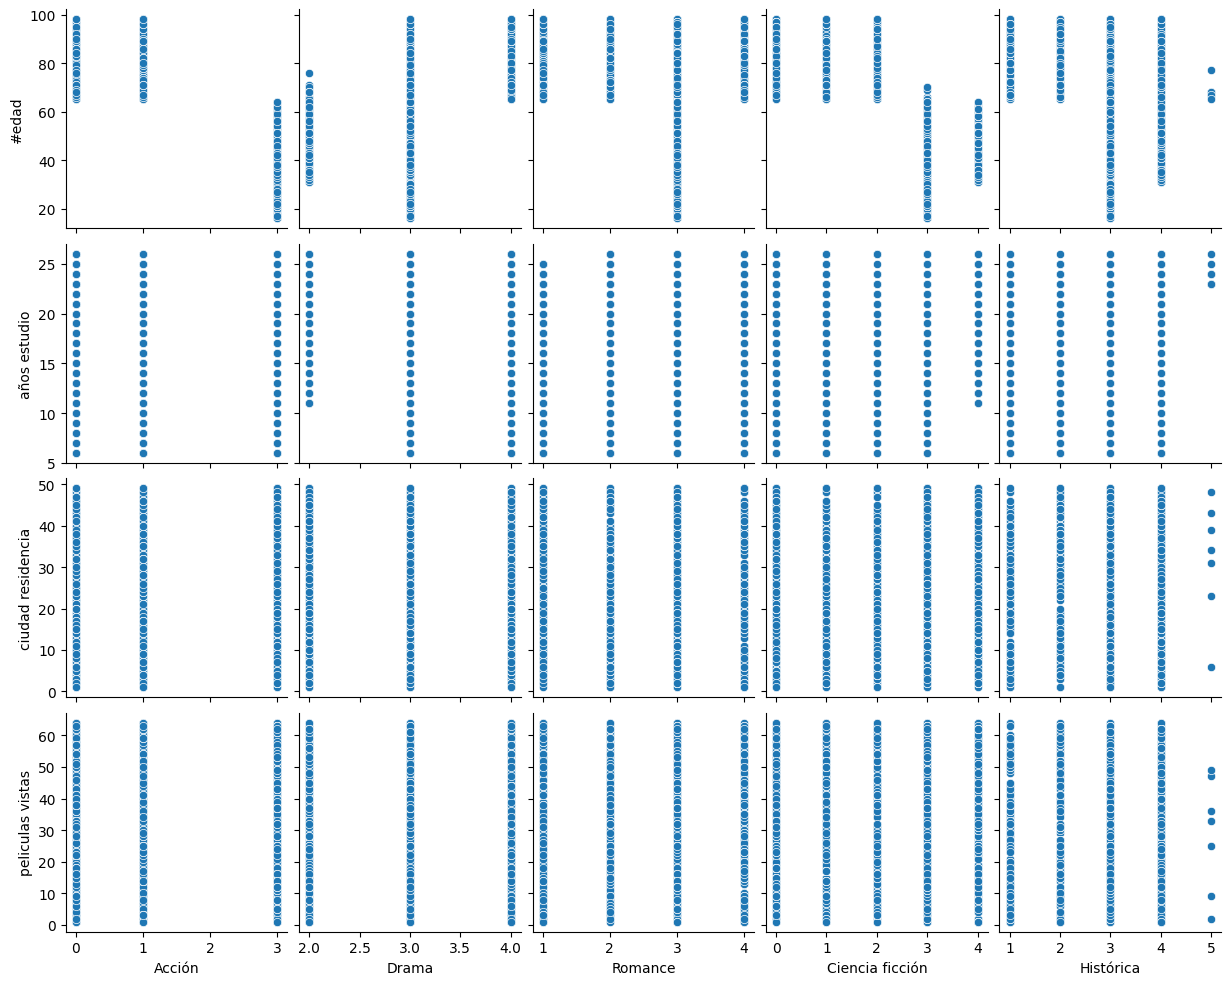

In [6]:
sns.pairplot(data=peliculas_df,
                  x_vars=peliculas_df.columns[4:],
                  y_vars=peliculas_df.columns[:4])
# Tal como en años de estudio, las variables de ciudad de residencia y el número de películas vistas al año, parecen no tener correlación con las variables de respuesta.

# As in 'años estudio', 'ciudad de residencia' and 'no. peliculas vistas año pasado' seem to have no correlation with the response variables.

<Axes: >

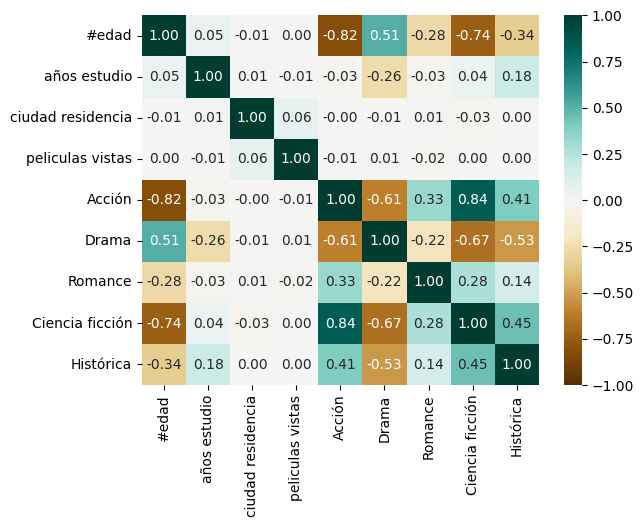

In [7]:
sns.heatmap(peliculas_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt = '.2f')
# As expected, there is no correlation

# Modelos

Tenemos dos opciones (igual que el documento anterior):
1. El modelo para edad (no mostrado)
2. Incluir las variables restantes usando vecinos cercanos


<font color='gray'>*Model*

*There are two options (same as the previous document):*
1. *The same model as step_one (age) (not shown)*
2. *Incluiding the remaining variables in KNeighborsClassifier*
</font>


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

In [10]:
class Recomendador3:
    def __init__(self):
        '''Predictions are ordered as:
            0: Less relevant
            4: More relevant'''
        pass

    def fit(self, X_train, y_train):
        '''
        X_train: (DataFrame) Datos de entrenamiento
        y_train: (DataFrame) Etiquetas de los datos de entrenamiento
        
        '''
        knn = KNeighborsClassifier(n_neighbors=19, weights='distance')
        self.model = MultiOutputClassifier(knn, n_jobs=-1,)
        self.model.fit(X_train,y_train)
        pass

    def predict(self, X_test):
        '''
        X_test: (iterador) Datos de prueba
        '''
        generos = ['Acción', 'Drama', 'Romance', 'Ciencia ficción', 'Histórica']
        # Convierte X_test a DF
        y_pred = pd.DataFrame(self.model.predict(X_test)) 
        # Acomoda los géneros según el sort_values de sus calificaciones predichas
        y_pred = y_pred.apply(lambda row: pd.Series(row.sort_values().index.map(lambda x: generos[x]).values), axis=1)
        return y_pred

    def score(self, X_test, y_test, y_pred):
        ''' Calcula el valor esperado de casillas correctas de la predicción '''
        y_pred_df = pd.DataFrame(y_pred)

        # Selección de su preferencia en términos de género como preorden total
        self.y_test_transf = y_test.apply(lambda sample: self._transform_sample(sample), axis = 1)

        # Comparar fila x fila
        comparing_bool = y_pred_df.reset_index(drop = True) == self.y_test_transf.reset_index(drop = True)
        number_success_df = pd.DataFrame(comparing_bool.apply(lambda row: row.sum(), axis = 1))
        distrib_success = number_success_df.groupby(0).agg({0: len})
        tot_success = distrib_success.sum().sum()
        tot_success

        distrib_success['p'] = distrib_success[0]/tot_success
        distrib_success['px'] = distrib_success['p'] * distrib_success.index
        self.E = distrib_success['px'].sum()
        return {'Esperanza':self.E, 'Score': self.model.score(X_test,np.array(y_test))}

    def _transform_sample(self, test_set):
        ''' transform score list -> total preordered genres list'''
        # test_set (index: edad, años estudio, cols: generos)
        y_transform = test_set.sort_values().index.values
        return pd.Series(y_transform)

## Testing

In [11]:
X = peliculas_df[peliculas_df.columns[:4]]#.values
y = peliculas_df.drop(peliculas_df.columns[:4], axis = 1)#.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2024)

In [12]:
R3 = Recomendador3()
R3.fit(X_train,y_train)
y_predict = R3.predict(X_test)
y_predict

,0,1,2,3,4
0,Acción,Drama,Romance,Ciencia ficción,Histórica
1,Acción,Romance,Ciencia ficción,Drama,Histórica
2,Acción,Drama,Romance,Ciencia ficción,Histórica
3,Acción,Ciencia ficción,Drama,Romance,Histórica
4,Acción,Drama,Romance,Ciencia ficción,Histórica
...,...,...,...,...,...
357,Acción,Drama,Romance,Ciencia ficción,Histórica
358,Acción,Drama,Romance,Ciencia ficción,Histórica
359,Ciencia ficción,Acción,Histórica,Drama,Romance
360,Drama,Acción,Romance,Ciencia ficción,Histórica


In [13]:
R3.score(X_test, y_test, y_predict)

{'Esperanza': 3.6906077348066297, 'Score': 0.45027624309392267}